In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from fsha import *
from datasets import image
from models import resnet
import pickle

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2022-03-02 17:31:46.601820: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 17:31:47.389438: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16846 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:d8:00.0, compute capability: 7.5


In [3]:
target_ds, aux_ds = image.load_celeba()

In [4]:
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,          # tuned according to paper
    'lr_tilde': 0.00001,        # tuned according to paper
    'lr_D': 0.0001,             # tuned according to paper
    'lr_g': 0.001               # given original task lr
}

iterations = 30000
log_frequency = 500

celeba_fsha = {}
log = {}

for split in [2,3,4]:
    print("============================")
    print("======Split level is {}======".format(split))
    print("============================")
    make_f, make_g, make_e, make_d, make_c = resnet.make_resnet_fsha(split=split, class_num=10)
    models = (make_f, make_g, make_e, make_d, make_c)

    # From "Unleashing the tiger: feature inference attacks in split learning"
    if split == 4:
        hparams['lr_D'] = 0.0005

    celeba_fsha["celeba-split="+str(split)] = FSHA(target_ds, aux_ds, models=models, batch_size=64, hparams=hparams)
    log["celeba-split="+str(split)] = celeba_fsha["celeba-split="+str(split)](iterations, verbose=True, progress_bar=False, log_frequency=log_frequency)

======Split level is 2======
RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP


2022-03-02 17:32:15.947680: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-03-02 17:32:16.703396: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 17:32:16.704388: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 17:32:16.704424: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-03-02 17:32:16.706028: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-02 17:32:16.706384: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Iteration 0000000 train loss: 3.1493, validation: 0.4567
Iteration 0000500 train loss: 0.3653, validation: 0.2922
Iteration 0001000 train loss: 0.1557, validation: 0.1132
Iteration 0001500 train loss: 0.1137, validation: 0.0841
Iteration 0002000 train loss: 0.0942, validation: 0.0706
Iteration 0002500 train loss: 0.0916, validation: 0.0639
Iteration 0003000 train loss: 0.0995, validation: 0.0592
Iteration 0003500 train loss: 0.0852, validation: 0.0571
Iteration 0004000 train loss: 0.0897, validation: 0.0556
Iteration 0004500 train loss: 0.0870, validation: 0.0535
Iteration 0005000 train loss: 0.0678, validation: 0.0517
Iteration 0005500 train loss: 0.0886, validation: 0.0499
Iteration 0006000 train loss: 0.0719, validation: 0.0487
Iteration 0006500 train loss: 0.0675, validation: 0.0473
Iteration 0007000 train loss: 0.0672, validation: 0.0459
Iteration 0007500 train loss: 0.0654, validation: 0.0451
Iteration 0008000 train loss: 0.0646, validation: 0.0441
Iteration 0008500 train loss: 0

In [5]:
with open('log/celeba-fsha.pkl', 'wb') as f:
    pickle.dump(log, f)

tf.Tensor(0.032974657, shape=(), dtype=float32)
tf.Tensor(0.03803929, shape=(), dtype=float32)
tf.Tensor(0.057672948, shape=(), dtype=float32)


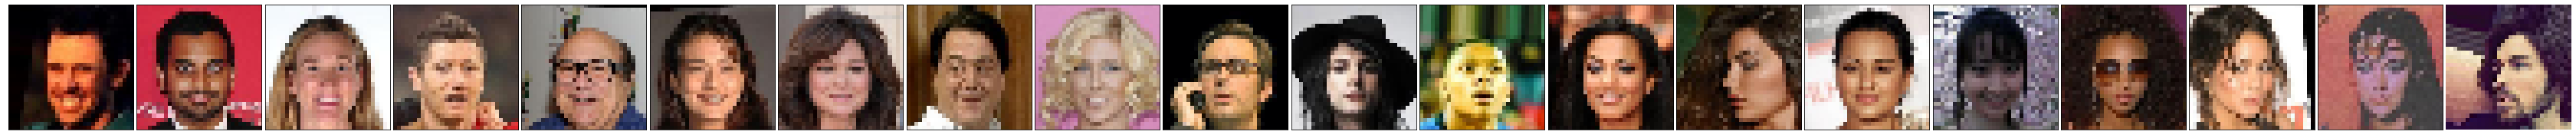

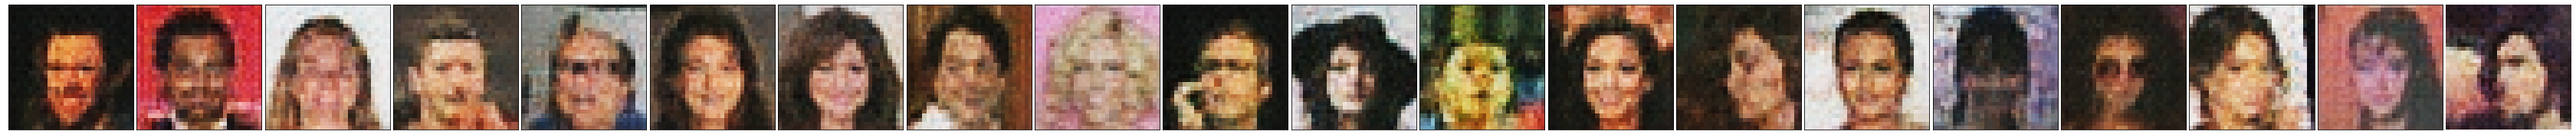

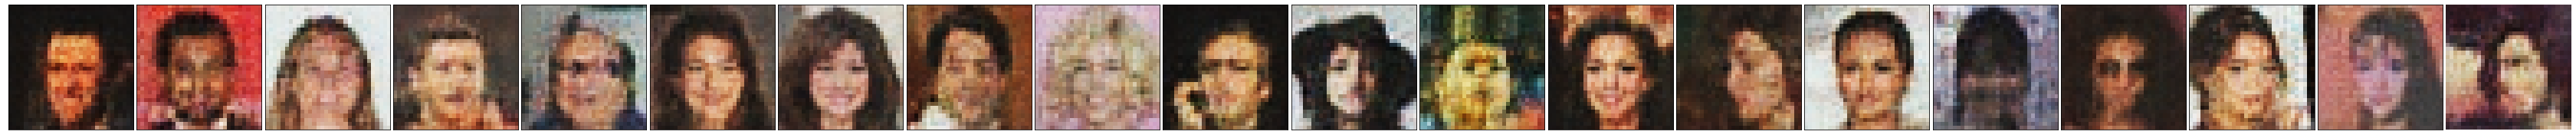

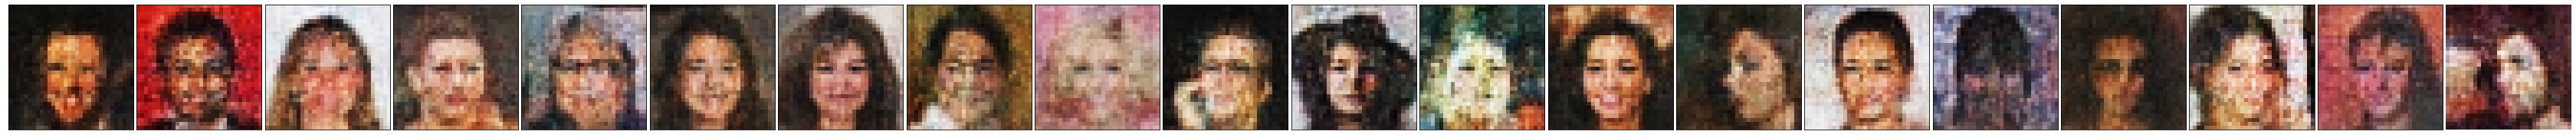

In [8]:
imgs = image.load_celeba(take_first=20)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i]), cmap='inferno')
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
    return fig

fig = plot(imgs)
for split in [2,3,4]:
    rec_res, _ = celeba_fsha["celeba-split="+str(split)].attack(imgs)
    fig = plot(rec_res)
    print(tf.keras.losses.MeanSquaredError()(imgs, rec_res))

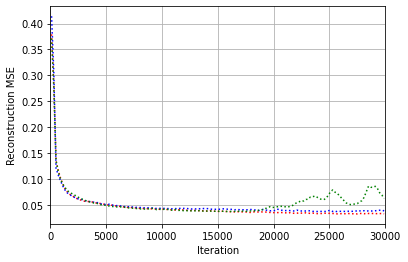

In [14]:
log1 = log
with open('log/celeba-fsha.pkl', 'rb') as f:
    log = pickle.load(f)
# with open('log/celeba.pkl', 'rb') as f:
#     log1 = pickle.load(f)

from matplotlib.pyplot import figure
# figure(figsize=(6.4,4.8))
log_freq = 200
# plt.yscale('logit')
plt.xlim([0,30000])
# plt.ylim([0.00, 0.3])
plt.grid()
sampled_log_2 = [sum(log["celeba-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["celeba-split=2"][:,0])/log_freq))]
sampled_log_3 = [sum(log["celeba-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["celeba-split=3"][:,0])/log_freq))]
sampled_log_4 = [sum(log["celeba-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log["celeba-split=4"][:,0])/log_freq))]
# sampled_log1_2 = [sum(log1["celeba-split=2"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log1["celeba-split=2"][:,0])/log_freq))]
# sampled_log1_3 = [sum(log1["celeba-split=3"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log1["celeba-split=3"][:,0])/log_freq))]
# sampled_log1_4 = [sum(log1["celeba-split=4"][:,1][i*log_freq:(i+1)*log_freq])/log_freq for i in range(int(len(log1["celeba-split=4"][:,0])/log_freq))]
ran = [i * log_freq + log_freq/2 for i in range(int(30000/log_freq))]
plt.plot(
    ran, sampled_log_2, 'r:',
    ran, sampled_log_3, 'b:',
    ran, sampled_log_4, 'g:',
    # ran, sampled_log1_2, 'ro-',
    # ran, sampled_log1_3, 'b^-',
    # ran, sampled_log1_4, 'gs-',
    markevery=11)
plt.ylabel('Reconstruction MSE')
plt.xlabel('Iteration')
# plt.legend(["FSHA (split level 2)", "FSHA (split level 3)", "FSHA (split level 4)", "Ours (split level 2)", "Ours (split level 3)", "Ours (split level 4)"])
plt.savefig("fig/celeba-fsha-dsa.pdf", bbox_inches='tight')